# Chapter 7: Modeling the visual field (with FilterNet)

FilterNet is a part of the BMTK that simulates the effects of visual input onto cells in the LGN. It uses LGNModel as a backend, which uses neural-filters to simulate firing rates and spike-trains one may expect given a stimulus on (especially mouse) visual field. FilterNet supports a number of visual stimuli including static-graitings, moving-graiting, full-field flashes, static images and even movies.

Filternet uses a [__linear-nonlinear-Poisson (lnp) model__](https://en.wikipedia.org/wiki/Linear-nonlinear-Poisson_cascade_model), using a spatial-temporal linear filter to convert a movie into a series of spike trains.

![](./images/filternet_lnp.png)

## A simple example

#### 1. Building the network

FilterNet is modeled on the mammalian LGN and expects a two-dimensional network of cells that can be mapped onto the receptive field. The default parameters of the filters are based on experimental recordings from the mouse LGN [Durant et. al, 2016, Billeh et. al, 2019] As our starting case we will have a simple network of 20 ON cells and 20 OFF cells with coordinates that correspond to the 240x120 movie we will be playing against it.





In [13]:
import numpy as np
from bmtk.builder import NetworkBuilder


net = NetworkBuilder('lgn')  # Initialize network called 'lgn'

net.add_nodes(  # add 10 simple ON cells
    N=20, 
    model_type='virtual',
    model_template='lgnmodel:tOFF_TF15',
    x=np.random.uniform(0.0, 240.0, 20),
    y=np.random.uniform(0.0, 120.0, 20),
    dynamics_params='tON_TF15.json'
)

net.add_nodes(  # add 10 simple OFF cells
    N=20, 
    model_type='virtual',
    model_template='lgnmodel:tON',
    x=np.random.uniform(0.0, 240.0, 20),
    y=np.random.uniform(0.0, 120.0, 20),
    dynamics_params='tOFF_TF15.json'
)

# Create and save the network
net.build()
net.save_nodes(output_dir='sim_ch07/network')


#### 2. Setting up the simulation enviornment

The following will create the necessarcy python and configuration files to run a simulation, all placed in the __sim_ch07__ directory.

In [14]:
from bmtk.utils.sim_setup import build_env_filternet

build_env_filternet(
    base_dir='sim_ch07', 
    network_dir='sim_ch07/network', 
    tstop=3000.0,                   # run the simulation for 3 seconds 
    include_examples=True)          # includes

The most important file that we will want to change is the __simulation_config.json__ which contains information about the simulation. 

By default the config file does not contain any stimulus so the firing rate will simply be at the baseline firing rate. To change this and play a certain type of movie/stimulus, which here we'll use a movie with a bright flash full-screen for an extend period of time. To do so open up simulation_config.json and add the following inputs section:

```json
"inputs": {
    "full_field_flash": {
        "input_type": "movie",
        "module": "full_field_flash",
        "row_size": 120,
        "col_size": 240,
        "t_on": 1000.0,
        "t_off": 2000.0,
        "max_intensity": 20.0
    }
},
```

This will create a flash on the screen from 1 to 2 seconds.

#### 3 Running the simulation

You can run the simulation from the command line by going to the __sim_ch07__ directory and running:
```bash
  $ python run_filternet.py simulation_config.json
```

And if you have MPI installed with access to a cluster you can parallize much of the process

```bash
 $ mpirun -np $NCORES python run_filternet.py simulation_config.json
```

or we can run it directly

In [16]:
from bmtk.simulator import filternet

config = filternet.Config.from_json('sim_ch07/simulation_config.json')
config.build_env()
net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

2020-01-03 13:15:56,482 [INFO] Created log file


INFO:FilterNetIOUtils:Created log file


2020-01-03 13:15:56,525 [INFO] Building cells.


INFO:FilterNetIOUtils:Building cells.


2020-01-03 13:15:57,835 [INFO] Evaluating rates.


INFO:FilterNetIOUtils:Evaluating rates.


2020-01-03 13:15:57,837 [INFO] Done.


INFO:FilterNetIOUtils:Done.


This will generate a number of files in the __output__ directory, including __rates.csv__ that contains the firing rate of each cell over the duration of the simulation, and __spikes.h5__ in which the rates have been converted to spike times using a nonhomogeneous Poisson process.

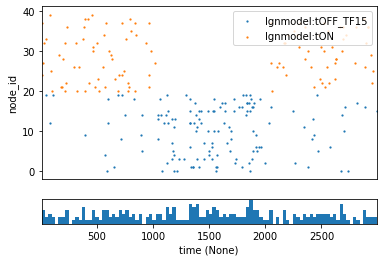

In [25]:
from bmtk.analyzer.visualization.spikes import plot_raster

plot_raster('sim_ch07/output/spikes.h5', nodes_file='sim_ch07/network/lgn_nodes.h5', 
            node_types_file='sim_ch07/network/lgn_node_types.csv', group_by='model_template')

As expected, the flash from 1 to 2 seconds caused the ON cells to temporary increase firing while also supressing the OFF cells.

## Running different types of Stimuli

Currently FilterNet allows for a number of different types of custom and pre-alligned type of stimuli. To change the type of stimuli requires updating the _inputs_ section in the __simulation_config.json__ file like above. 

### _movie_

Allows playing a custom movie file in the form of a three-dimension matrix saved in a [npy file](https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html). 

_example_
```json
"inputs": {
    "movie_input": {
        "input_type": "movie",
        "module": "movie",
        "data_file": "/path/to/my/movie.npy",
        "frame_rate": 30.0
        }
    }
},
```

### _grating_

Plays a drifting grating across the screen

_example_
```json
"inputs": {
  "LGN_spikes": {
    "input_type": "movie",
    "module": "graiting",
    "row_size": 120,
    "col_size": 240,
    "gray_screen_dur": 0.5,
    "cpd": 0.04,
    "temporal_f": 4.0,
    "contrast": 0.8,
    "theta": 45.0,
    "phase": 0.0
  }
},
```

_parameters_
* __row_size__, __col_size__ - width and heigth dimensions of screen in pixels.
* __grapy_screen_dur__ - displays an optional gray screen for a number of seconds before the grating starts. (default: 0)
* __cpd__ - spatial frequncy represented as cycles per degree. (default: 0.05)
* __temporal_f__ - temporal frequency in Hz. (default: 4.0)
* __theta__: orientation angle, in degrees (default: 45.0)
* __phase__: temporal phase, in degrees (default: 0.0)
* __contrast__: the maximum constrast, must be between 0 and 1.0 (default: 1.0)


### _full field flash_

Creates a bright (or dark) flash on a gray screen for a limited number of seconds

_example_
```json
"inputs": {
    "full_field_flash": {
        "input_type": "movie",
        "module": "full_field_flash",
        "row_size": 120,
        "col_size": 240,
        "t_on": 1000.0,
        "t_off": 2000.0,
        "max_intensity": 20.0
    }
},
```


### _looming_

_example_


```json
"inputs": {
  "LGN_spikes": {
    "input_type": "movie",
    "module": "looming",
    "row_size": 120,
    "col_size": 240,
    "frame_rate": 1000.0,
    "gray_screen_dur": 0.5,
    "t_looming": 1.0
  }
},
```

## Units

### simple ON/OFF cells
These are cells that respond by either increasing or decreasing firing rates to brightness changes in their receptive fields. They are also the basis for more advanced cell types. When building a network you can set a cell or set of cells with ```model_template='lgnmodel:tON'``` or ```model_template='lgnmodel:tOFF'``` during the call to ```add_nodes(...)```. There are also a number of special types (```tON_TF8, sON_TF1, sON_TF2, sON_TF4, sON_TF8, sON_TF15, tOFF_TF1, tOFF_TF2, tOFF_TF4, tOFF_TF8, tOFF_TF15, sOFF_TF1, sOFF_TF2, sOFF_TF4, sOFF_TF8, sOFF_TF15```) which have properties that have been pre-calculated using electrophysiological recordings from the mouse LGN (Durant et. al 2016, Billeh et. al 2019).



A combination of a Gaussian spatial filter and double cosine temporal filter are used to filter the receptive field.

<div class="row">
  <div class="col-md-4" markdown="1">
  <img height="1000px" width="1000px"  src="./images/filternet_spat_filter.png">
  </div>
  <div class="col-md-4" markdown="1">
  <img height="300px" width="300px" src="./images/filternet_temp_filter.png">
  </div>
</div>

#### parameters

The parameters for the cell are by default set in the .json file pointed to by the ```dynamic_params``` parameter are calculated from extracellular recordings from the mouse LGN (Durand et. al 2016, Billeh et. al, 2019). These parameters may be over ridden to be unique to each cell by passing in a list of values in the call to ```add_nodes```. For example to given every cell a randomized spontaneous firing rate using the spont_fr variable (see below) you would just add the following:
```python
net.add_nodes(  # add 10 simple ON cells
    N=20, 
    model_template='lgnmodel:tON',
    spont_fr=np.random.uniform(1.0, 2.0, 20) # create a rand list of 20 firing rates between 1 to 2 Hz
    ....
)
```

__*spatial filter parameters*__
* *spatial_size*: (float, float) - the row and column spread of the gaussian filter, default: (1.0, 1.0)
* *spatial_rotation*: float - the gaussian rotation in degrees, default: 0.0

![](./images/filternet_sfilt_params.png)

__*temporal filter parameters*__
* *weights*: (float, float) - used to control amplitude of the the two bumps in cosine filter. The first value is used to set the major bump and must have weights[0] > weights[1]
* *kpeaks*: (float, float) - used to control the spread of the two bumps, the first value for the initial larger peak and the second for the smaller peak. The second peak must have a greater spread than the first.
* *delays*: (float, float) - controls the delays of the first and second bumps

![](./images/filternet_tfilt_params.png)

__*non-linear filter parameters*__
* *spont_fr*: float - The spontaneous/resting firing rate of the cell. ON/OFF cells use the function $Heaviside(s+spont\_fr)*(s+spont\_fr)$ to filter the firing rate following the spatialtemporal filter. 


### Spatial Mixture cells
These types of units combine two spatial filters to create a [Mexican hat](https://en.wikipedia.org/w/index.php?title=Mexican_Hat_Function) filter so the spatial filter responds to a bright area surrounded by darkness (or vice-versa). To use set ```model_template='lgnmodel:LGNOnOFFCell'```

__*parameters*__
* *sigma_on*: (float, float) - spread of the ON region of the spatial filter.
* *sigma_off*: (float, float) - spread of the OFF region of the spatial filter.

The temporal filter is set using the same parameters as a simple cell. 


### Dual filter cells (sONtOFF, sONsOFF)

These units combine two simple linear filters into one, and can be set using either ```model_template='lgnmodel:sONsOFF'``` or ```model_template='lgnmodel:sONtOFF'```, both with a non-dominate spatial-off filter.

__*parameters*__

The parameters for the first filter (tOFF or sOFF subunit) is set using the same parameters as a simple cell. You can set non-dominate secondary subunit parameters in two ways:
1. Adding parameter *non_dom_params* that points to a second dynamics_params .json file. (eg. ```non_dom_params='sON_TF8.json'```)
2. add the postfix *_non_dom* to the specified params (eg. weights_non_dom, kpeaks_non_dom, delays_non_dom)